<a href="https://colab.research.google.com/github/WBNogueira/Transfer_Learning/blob/main/Redes_neurais_Transfer__Learning_catsXdogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Baixando arquivo de gatos e cachorros

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-11-13 21:23:51--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 142.250.188.48, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   262MB/s    in 0.3s    

2022-11-13 21:23:51 (262 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



#### Descompactando arquivo zipado

In [3]:
!rm -rf cats_and_dogs_filtered.zip

In [4]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [7]:
dataset_dir = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')

dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_train_cats_len = len(os.listdir(os.path.join(dataset_train_dir, 'cats')))
dataset_train_dogd_len = len(os.listdir(os.path.join(dataset_train_dir, 'dogs')))

dataset_validation_dir = os.path.join(dataset_dir, 'validation')
dataset_validation_cats_len = len(os.listdir(os.path.join(dataset_validation_dir, 'cats')))
dataset_validation_dogs_len = len(os.listdir(os.path.join(dataset_validation_dir, 'dogs')))

print('Train Cats: %s' % dataset_train_cats_len)
print('Train Dogs: %s' % dataset_train_dogs_len)
print('Validation Cats: %s' % dataset_validation_cats_len)
print('Validation Dogs: %s' % dataset_validation_dogs_len)

Train Cats: 1000
Train Dogs: 500
Validation Cats: 500
Validation Dogs: 500


In [20]:
image_width = 160
image_height = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)

batch_size = 32
epochs = 20
learning_rate = 0.0001

class_names = ['cat', 'dog']

In [21]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 2000 files belonging to 2 classes.


In [22]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 1000 files belonging to 2 classes.


In [23]:
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation)
dataset_validation_batches = dataset_validation_cardinality // 5

dataset_test = dataset_validation.take(dataset_validation_batches)
dataset_validation = dataset_validation.skip(dataset_validation_batches)

print('Validation Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_validation))
print('Test Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_test))

Validation Dataset Cardinality: 26
Test Dataset Cardinality: 6


In [24]:
def plot_dataset(dataset):
  plt.gcf().clear()
  plt.figure(figsize = (15, 15))

  for features, labels in dataset.take(1):

    for i in range(9):

      plt.subplot(3, 3, i + 1)
      plt.axis('off')

      plt.imshow(features[i].numpy().astype('uint8'))
      plt.title(class_names[labels[i]])

<Figure size 432x288 with 0 Axes>

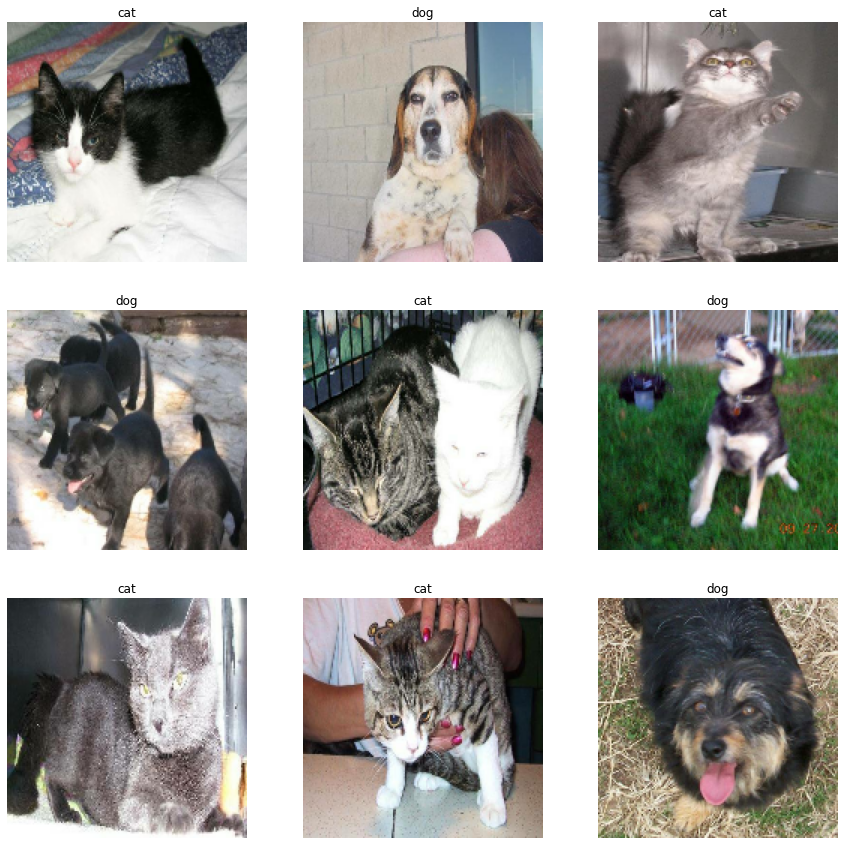

In [25]:
plot_dataset(dataset_train)

<Figure size 432x288 with 0 Axes>

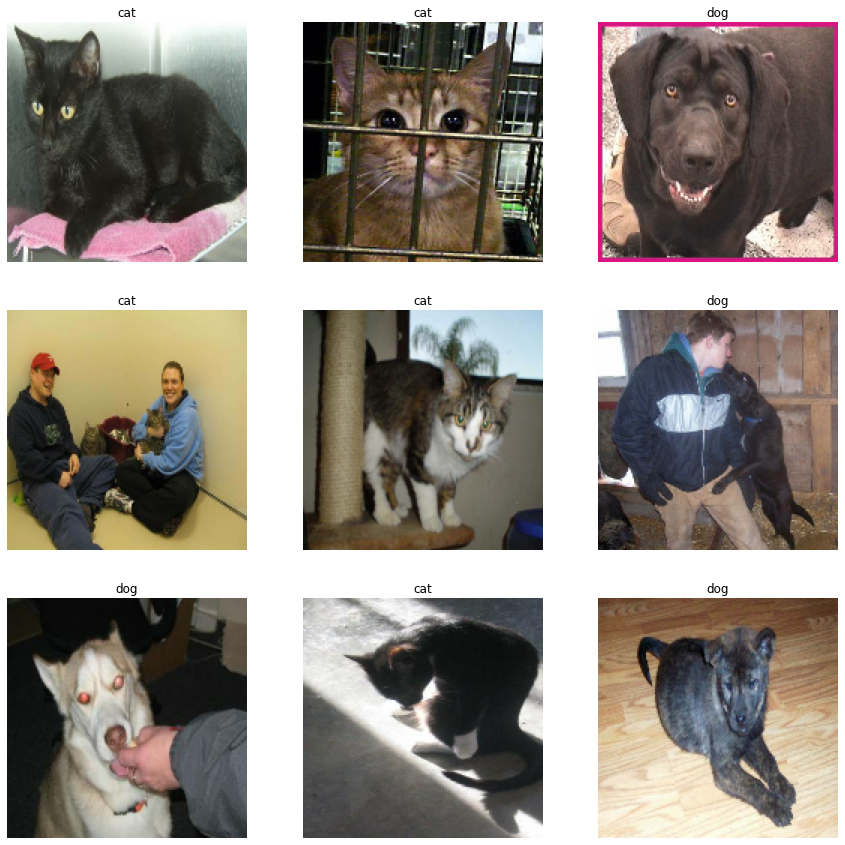

In [26]:
plot_dataset(dataset_validation)

<Figure size 432x288 with 0 Axes>

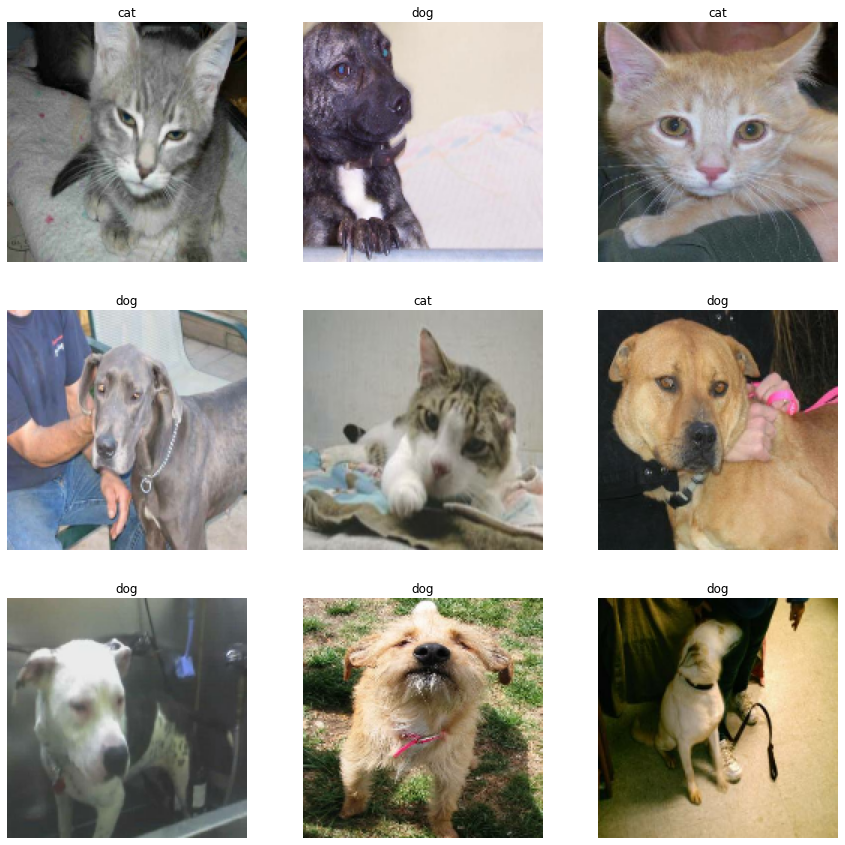

In [27]:
plot_dataset(dataset_test)

#### Criando o modelo

In [44]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [45]:
def plot_dataset_data_augmentation(dataset):

  plt.gcf().clear()
  plt.figure(figsize = (15, 15))

  for features, _ in dataset.take(1):

    feature = features[0]

    for i in range(9):

      feature_data_augmentation = data_augmentation(tf.expand_dims(feature, 0))

      plt.subplot(3, 3, i + 1)
      plt.axis('off')

      plt.imshow(feature_data_augmentation[0] / image_color_channel_size)

In [47]:
plot_dataset_data_augmentation(dataset_train)

<Figure size 432x288 with 0 Axes>

In [48]:
model_transfer_learning = tf.keras.applications.MobileNetV2(
    input_shape = image_shape,
    include_top = False,
    weights = 'imagenet'
)

model_transfer_learning.trainable = False

model_transfer_learning.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [50]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(
        1. / (image_color_channel_size / 2),
        offset = -1,
        input_shape = image_shape
    ),
    data_augmentation,
    model_transfer_learning,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [51]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validation,
    epochs = epochs
)

Epoch 1/20
63/63 [==============================] - 50s 733ms/step - loss: 0.6637 - accuracy: 0.6410 - val_loss: 0.4725 - val_accuracy: 0.8069
Epoch 2/20
63/63 [==============================] - 41s 645ms/step - loss: 0.4967 - accuracy: 0.7705 - val_loss: 0.3507 - val_accuracy: 0.8911
Epoch 3/20
63/63 [==============================] - 41s 657ms/step - loss: 0.4136 - accuracy: 0.8255 - val_loss: 0.2819 - val_accuracy: 0.9208
Epoch 4/20
63/63 [==============================] - 39s 623ms/step - loss: 0.3458 - accuracy: 0.8710 - val_loss: 0.2431 - val_accuracy: 0.9282
Epoch 5/20
63/63 [==============================] - 40s 630ms/step - loss: 0.3104 - accuracy: 0.8850 - val_loss: 0.1996 - val_accuracy: 0.9505
Epoch 6/20
63/63 [==============================] - 40s 637ms/step - loss: 0.2737 - accuracy: 0.8960 - val_loss: 0.1722 - val_accuracy: 0.9579
Epoch 7/20
63/63 [==============================] - 40s 633ms/step - loss: 0.2777 - accuracy: 0.8995 - val_loss: 0.1621 - val_accuracy: 0.9579

In [52]:
def plot_model():
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.gcf().clear()
  plt.figure(figsize = (15, 8))

  plt.subplot(1, 2, 1)
  plt.title('Training and Validation Accuracy')
  plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
  plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
  plt.legend(loc = 'lower right') 

  plt.subplot(1, 2, 1)
  plt.title('Training and Validation Loss')
  plt.plot(epochs_range, loss, label = 'Training Loss')
  plt.plot(epochs_range, val_loss, label = 'Validation Loss')
  plt.legend(loc = 'lower right')

  plt.show()

In [53]:
plot_model();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

In [54]:
def plot_dataset_predictions(dataset):

  features, labels = dataset.as_numpy_iterator().next()

  predictions = model.predict_on_batch(features).flatten()
  predictions = tf.where(predictions < 0.5, 0, 1)

  print('Labels:       %s' % labels)
  print('Predictions:  %s' % predictions.numpy())

  plt.gcf().clear()
  plt.figure(figsize = (15, 15))

  for i in range(9):
    plt.subplot( 3, 3, i + 1)
    plt.axis('off')

    plt.imshow(features[i].astype('uint8'))
    plt.title(class_names[predictions[i]])

Labels:       [1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1]
Predictions:  [1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1]


<Figure size 432x288 with 0 Axes>

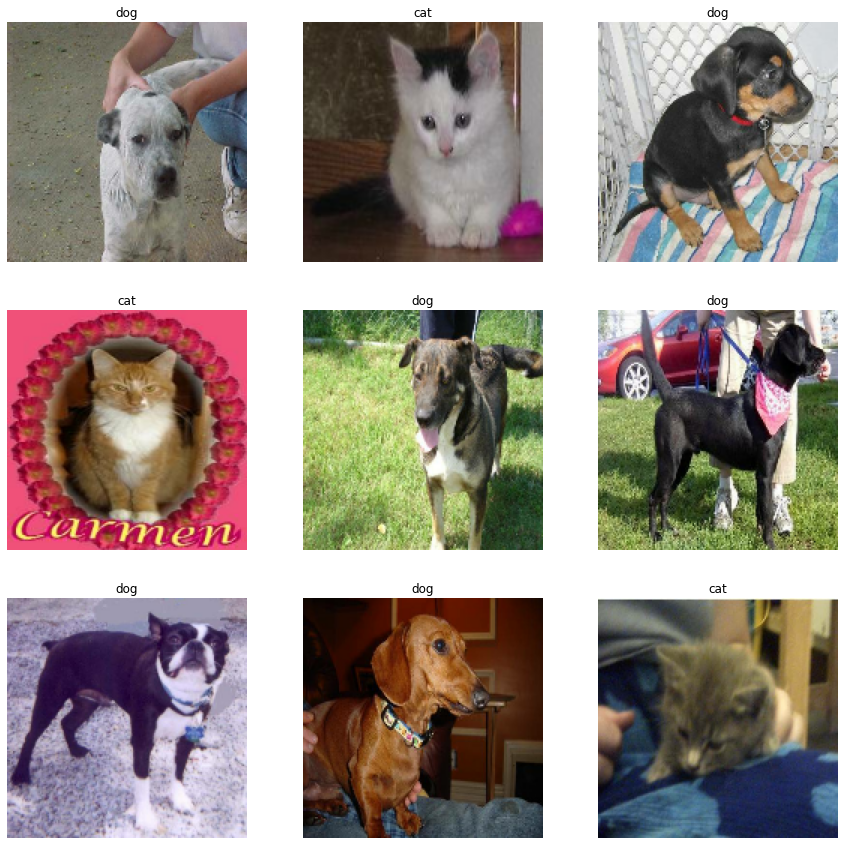

In [55]:
plot_dataset_predictions(dataset_test)

In [56]:
model.save('path/to/model')

In [57]:
model = tf.keras.models.load_model('path/to/model')